In [1]:
import getpass
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Dict, Any
import openai 
# from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
from textwrap import dedent
import json

In [2]:
# Prompts
TARGET_DOMAIN = dedent("""
        As a Domain Analysis Specialist, extract all the core innovation domains from the user query. It could be a single one for a simple query, or multiple ones for a complex query.
        Instructions:
        1. Analyze the user's input
        2. Identify the primary domain(s) requiring innovation
        3. Classify it within standard innovation categories
        Output Format:
        Target Domain: [Clear, specific domain label]
        Be very detailed and specific in your response and do not generalize. Respond ONLY with the name of the domain, do NOT include ANY other text like 'Target Domain:'.
        User query: {user_query}
""").strip()

PROBLEM_LANDSCAPE = dedent("""
        You are a Problem Landscape Analyst. Your task is to map out the concrete challenges within the target domain identified.
        Instructions:
        1. Identify all the core problems or challenges currently present in these domains. Aim for at least 3 problems per domain
        2. For each problem, provide:
        - Problem: A short, clear title.
        - Description: 2-3 sentences explaining what the problem is and why it matters.
        - Context: Briefly state the circumstances or environment where this problem occurs.
        - Stakeholders: List the main groups or individuals affected.
        - Root Causes: Identify 1-3 underlying causes, if known.
        - Impact: State the significance of the problem (e.g., social, economic, technical).
        - Current Approaches: How is this problem currently addressed?
        - Limitations: What are the shortcomings of current approaches?
        - Success Metrics: How would you measure if this problem is solved?
        - Interconnections: Note if this problem is linked to or influenced by other problems.
        Output Format:
        Present your findings as a structured list or JSON array, with each problem fully described as above.
        Important:
        - Focus on clarity and completeness.
        - Avoid abstracting or generalizing; stay concrete and domain-specific.
        - Do not propose solutions; only describe the current problem landscape.
        Target domain: {target_domain}
""").strip()

ABSTRACTION = dedent("""
You are a TRIZ Methodology Expert. Transform domain-specific problems into universal contradictions.

Process:
1. Read up on TRIZ - the contradiction matrix, and the inventive principles
2. For each problem in the problem landscape:
   - Abstract to universal parameters (what improves vs. what worsens)
   - Express as 'When we improve X, Y worsens'
   - Ensure parameters are domain-agnostic
3. Analyze all the abstracted universal parameters, and identify all the core TRIZ contradictions present:
   - Select the most fundamental tensions
   - Map to TRIZ contradiction matrix
   - Note applicable inventive principles

Output as a JSON list with this exact format:
"
[
  {{
    "contradiction": "Improving [parameter] vs. Worsening [parameter]",
    "principles": "[1-3 relevant TRIZ principles with numbers]",
    "potential": "High/Medium/Low"
  }}
]
"

Focus on contradictions that, if resolved, would create breakthrough value.
                     
Problem landscape: {problem_landscape}
""").strip()


BASE_DOMAIN = dedent("""
        You are a Cross-Domain Search Specialist. Do the following:
        - For each contradiction provided, identify 3 distinct source domains (fields or industries) where this contradiction has been successfully addressed.
        - Experiment with different subsets of the list of contradictions, and see if you could identify 3 distinct source domains for each of these subsets identified as well. You should find at least 3 different subsets.
        Note: The domains should have A CONCEPTUAL DISTANCE OF AT LEAST 3 DISTINCT HOPS FROM WHAT IMMEDIATELY COMES TO MIND. Be creative! It can be domains within spheres like natural, phsyical, social, artistic, or anything.
        For each domain identified, briefly explain why it is relevant to the single contradiction or the subset of contradictions identified. Do not describe specific solutions just yet-only list the domains and your rationale.
        Output:
        A list for each contradiction and subset of contradictions identified, naming 3 relevant domains with a 2 sentence rationale for each.
        Aim for a total of at least 20 relevant base domains. 
        Contradictions: {contradictions}
""").strip()

BASE_SOLUTIONS = dedent("""
        You are a Solution Pattern Extractor. You are provided with an input with 3 base domains identified per TRIZ (Theory of Inventive Problem Solving) contradiction or a set of contradictions, as well as the contradictions themselves.
        For each of these identified base domains, identify one specific, well-documented solution pattern within the domain that effectively resolves the contradiction (or the set of contradictions).
        For each solution pattern, return:
        - Identify the base domain it's corresponding to
        - Recall the contradiction or the set of contradictions that this base domain faces
        - The name or label of the solution pattern for resolving these contradiction(s) in the base domain
        - A detailed description of the core mechanism or principle involved and how it addressed the domain's contradiction(s)
        - The context or situation in the domain where this pattern is applied\n"
        Do not generalize or adapt the solution-simply describe how the contradiction is addressed within each source domain.
        Output:
        For each of the provided domain, list the base domain name, contradiction(s) faced, solution pattern name, the detailed description of the mechanism of the solution pattern, and the context in which it is used. Articulate the contradictions as problems and considerations faced, through framing them as a tension.

        Input: {input}
""").strip()

ANALOGICAL_TRANSFER = dedent("""
You are a very innovative Analogical Transfer Specialist.
You are provided with list the base domain name, tensions faced, solution pattern name, the detailed description of the mechanism of the solution pattern, and the context in which it is used.
Your task is to propose how solution patterns used to resolve these tensions in various base domains might inspire solution framings for the original target domain.

Input Overview:
1. A list the base domains identified, the tensions these domains faced, the name of solution patterns that helped addressed these tensions in these base domains, the detailed description of the mechanism of the solution pattern, and the context in which it is used.
2. The original target domain.

Instructions:
For each pair of base domain and the corresponding tensions identified, review the solution patterns that worked for the base domain. For each pattern:
- Analyze the core mechanism or principle behind the solution.
- Map and adapt this mechanism conceptually to the target domain, considering the specific context and needs of the target domain.
- Clearly describe how this analogical transfer could frame a potential solution in the target domain.
- Highlight any key adaptations, considerations, or limitations that would be relevant when applying this pattern to the target domain.

Output as a JSON list of dictionaries with this exact format:
"
[
  {{
    "transfer": "Brief title of the analogical transfer solution",
    "description": "Comprehensive description including: original tension, source domain and solution pattern, detailed explanation of target domain application, and key adaptations/considerations"
  }}
]
"

Here are the actual inputs:
- A list the base domains identified, the tensions these domains faced, the name of solution patterns that helped addressed these tensions in these base domains, the detailed description of the mechanism of the solution pattern, and the context in which it is used.: {contradictions_solutions}
- Original target domain: {target_domain}
""").strip()


In [3]:
# check for openai API
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

In [4]:
# parse_output
import re

def parse_solution(text):
    # Remove Markdown formatting like "**" and "\n"
    clean_text = text.replace("**", "").replace("\\n", "\n")

    # Split into sections by horizontal rules (---)
    sections = re.split(r'-{3,}', clean_text)

    # Create a readable version of each section
    readable_output = []
    for section in sections:
        section = section.strip()
        if not section:
            continue
        # Optional: separate title and body if present
        lines = section.split("\n")
        if len(lines) > 1 and ":" not in lines[0]:
            # First line is likely a heading
            heading = lines[0]
            body = "\n".join(lines[1:])
            readable_output.append(f"\n=== {heading} ===\n{body}")
        else:
            readable_output.append(section)

    return "\n\n".join(readable_output)

In [5]:
class ReasoningState(TypedDict):
    user_query: str
    target_domain: str
    problem_landscape: str
    abstraction: str
    abstraction_feedback: str
    base_domain: str
    base_solutions: str
    analogical_transfer: str
    transfer_feedback: str
    solution: str
    
    # Add for CRIT agents:
    retry_count_abstract: int              # For infinite loop prevention
    retry_count_transfer: int              # For infinite loop prevention
    validated_contradictions: List[str]    # For passing filtered contradictions
    validated_analogical_transfers: List[str]  # For passing filtered transfers

In [6]:
# Can switch between different LLMs 
llms = init_chat_model("openai:gpt-4.1")

In [7]:
# 1st Agent: Identify Target Domain from User Input
def target_domain_agent(state: ReasoningState):
    u = state['user_query']

    msg = llms.invoke(TARGET_DOMAIN.format(user_query=u))

    return {"target_domain": msg.content}

In [8]:
# 2st Agent: Conduct comprehensive research into problem landscape for target domain 
# (i.e. What specific challenges exist in this domain?)
def problem_landscape_agent(state: ReasoningState):
    t = state['target_domain']

    msg = llms.invoke(PROBLEM_LANDSCAPE.format(target_domain=t))

    return {"problem_landscape": msg.content}

In [9]:
# 3rd Agent: Abstract Problems Identified into Generalized Principles and TRIZ Contradiction
def abstraction_agent(state: ReasoningState):
    p = state['problem_landscape']
    feedback = state.get('abstraction_feedback', '')
    
    # If there's feedback, include it in the prompt
    if feedback:
        msg = llms.invoke(ABSTRACTION.format(
            problem_landscape=p,
            feedback=f"\nPrevious attempt feedback: {feedback}\nPlease address these issues in your new abstraction."
        ))
    else:
        msg = llms.invoke(ABSTRACTION.format(problem_landscape=p))
    
    return {"abstraction": msg.content}

In [10]:
## 3.5th agent: CRIT Quality Control for TRIZ Abstraction
def parse_abstraction_output(abstraction_text: str) -> list:
    """Parse JSON-formatted abstraction output."""
        # First try to parse as JSON if it's already in JSON format
    try:
        try:
            return json.loads(abstraction_text)
        except json.JSONDecodeError:
            pass

        # If not JSON, parse as text
        lines = [line.strip() for line in abstraction_text.split('\n') if line.strip()]
        contradictions = []
        
        current_contradiction = None
        for line in lines:
            # Clean the line of any markdown or extra whitespace
            clean_line = line.strip('- ').strip()
            
            if 'Improving' in clean_line and 'vs.' in clean_line:
                if current_contradiction:
                    contradictions.append(current_contradiction)
                current_contradiction = {
                    "contradiction": clean_line,
                    "principles": "",
                    "potential": ""
                }
            elif 'TRIZ Principles:' in clean_line and current_contradiction:
                current_contradiction["principles"] = clean_line.replace('TRIZ Principles:', '').strip()
            elif 'Innovation Potential:' in clean_line and current_contradiction:
                current_contradiction["potential"] = clean_line.replace('Innovation Potential:', '').strip()
                contradictions.append(current_contradiction)
                current_contradiction = None
        
        # Add the last contradiction if exists
        if current_contradiction:
            contradictions.append(current_contradiction)
        
        # Validate the parsed contradictions
        validated_contradictions = []
        for c in contradictions:
            if "contradiction" in c and c["contradiction"]:
                validated_contradictions.append(c)
        
        return validated_contradictions
        
    except Exception as e:
        print(f"Error parsing abstraction output: {str(e)}")
        print(f"Raw text: {abstraction_text}")
        return []

def CRIT_Control_Abstraction(target_domain: str, problem_landscape: str, triz_contradictions: str) -> dict:
    """Three-step CRIT validation workflow for TRIZ contradiction filtering."""
    
    # Parse contradictions from structured output
    parsed_contradictions = parse_abstraction_output(triz_contradictions)
    
    if not parsed_contradictions:
        return {
            "score": 0.0,
            "pass": False,
            "reason": "No valid contradictions found in the input",
            "validated_contradictions": [],
            "filtered_contradictions": []
        }
    
    try:
        # STEP 1: First CRIT Agent - Initial Filtering
        step1_prompt = f"""
# FIRST CRIT AGENT - Initial Socratic Filtering

Apply Professor Edward Y. Chang's CRIT (Critical Reading Inquisitive Template) methods using socratic methods to filter TRIZ contradictions into good and bad sets.

## CONTEXT
Target Domain: {target_domain}
Problem Landscape: {problem_landscape}
Contradictions to Evaluate: {parsed_contradictions}

## SOCRATIC FILTERING METHODS

### 1. DEFINITION METHOD
- Format: Does each contradiction follow "Improving [X] vs. Worsening [Y]"?
- Parameters: Are they legitimate TRIZ parameters?
- Abstraction: Are they at first-principles level?

### 2. ELENCHUS METHOD (Cross-Examination)
- Evidence: Can each contradiction trace back to specific problems?
- Logic: Is the causal chain Problem → Root Cause → Contradiction valid?
- Consistency: Any logical gaps in abstraction mapping?

### 3. DIALECTIC METHOD (Counter-Arguments)
- Alternatives: Are there better ways to express the same tension?
- Comparison: Which contradictions capture essential tensions best?
- Weakness: What are the strongest arguments against weak contradictions?

## FILTERING DECISION
Sort contradictions into two sets based on Socratic analysis:

### OUTPUT FORMAT
{{
    "good_contradictions": [
        {{"contradiction": str, "principles": str, "potential": str}}
    ],
    "bad_contradictions": [
        {{"contradiction": str, "principles": str, "potential": str, "reason": str}}
    ],
    "filtering_rationale": str
}}

Apply rigorous Socratic methods. Include rationale for why contradictions are filtered out.
        """
        
        response_1 = llms.invoke(step1_prompt)
        result_1 = parse_json_response(response_1.content)
        
        # STEP 2: Second CRIT Agent - Review and Revision
        step2_prompt = f"""
# SECOND CRIT AGENT - Socratic Review and Revision

Cross-examine the first agent's filtering decisions using CRIT methods.

## FIRST AGENT'S DECISIONS
Good Contradictions: {result_1.get('good_contradictions', [])}
Bad Contradictions: {result_1.get('bad_contradictions', [])}
Filtering Rationale: {result_1.get('filtering_rationale', '')}

## SOCRATIC CROSS-EXAMINATION

### 1. ELENCHUS METHOD (Challenge Decisions)
- Are any "good" contradictions actually flawed? Why?
- Are any "bad" contradictions actually valuable? Why?
- Do the filtering rationales hold up under scrutiny?

### 2. DIALECTIC METHOD (Counter-Arguments)
- Generate counter-arguments to the first agent's filtering rationale
- Test alternative interpretations of contradiction quality
- Challenge assumptions about what makes contradictions "good" or "bad"

### 3. MAIEUTICS METHOD (Surface Hidden Assumptions)
- What unstated assumptions influenced the first agent's decisions?
- Are there valid contradictions being unfairly penalized?
- What criteria were prioritized and why?

## REVIEW DECISION
Based on Socratic cross-examination:

### OUTPUT FORMAT
{{
    "revised_good_contradictions": [
        {{"contradiction": str, "principles": str, "potential": str}}
    ],
    "revised_bad_contradictions": [
        {{"contradiction": str, "principles": str, "potential": str, "reason": str}}
    ],
    "revision_rationale": str,
    "revisions_made": boolean
}}

If no revisions needed, return original sets with revisions_made: false.
        """
        
        response_2 = llms.invoke(step2_prompt)
        result_2 = parse_json_response(response_2.content)
        
        # STEP 3: First CRIT Agent - Final Synthesis
        step3_prompt = f"""
# FIRST CRIT AGENT - Final Synthesis

Synthesize the second agent's review with your own analysis to create final contradiction sets.

## SECOND AGENT'S REVIEW
Revised Good Contradictions: {result_2.get('revised_good_contradictions', [])}
Revised Bad Contradictions: {result_2.get('revised_bad_contradictions', [])}
Revision Rationale: {result_2.get('revision_rationale', '')}
Revisions Made: {result_2.get('revisions_made', False)}

## FINAL SOCRATIC SYNTHESIS

THINK ABOUT THE FOLLOWING
### 1. DIALECTIC INTEGRATION
- Consider the second agent's counter-arguments seriously
- Weigh competing interpretations of contradiction quality
- Resolve any remaining tensions between different quality standards

### 2. ELENCHUS VALIDATION
- Cross-examine the final decisions one more time
- Ensure logical consistency in the final sets
- Verify that filtering decisions are well-justified

### 3. PRACTICAL WISDOM
- Balance perfectionism with progress
- Ensure adequate contradictions for next pipeline stage
- Prioritize contradictions that best serve the target domain

## FINAL DECISION (MANDATORY)
Provide definitive contradiction sets for pipeline progression:

### OUTPUT FORMAT
{{
    "final_good_contradictions": [
        {{"contradiction": str, "principles": str, "potential": str}}
    ],
    "final_bad_contradictions": [
        {{"contradiction": str, "principles": str, "potential": str}}
    ],
    "synthesis_complete": boolean
}}

Must complete synthesis. Final decision required.
        """
        
        response_3 = llms.invoke(step3_prompt)
        result_3 = parse_json_response(response_3.content)
        
        # Extract final results
        final_good = result_3.get('final_good_contradictions', [])
        final_bad = result_3.get('final_bad_contradictions', [])
        
        # Convert to simple list format for pipeline compatibility
        validated_contradictions = [item['contradiction'] for item in final_good if 'contradiction' in item]
        filtered_contradictions = [item['contradiction'] for item in final_bad if 'contradiction' in item]
        
        # Calculate final pass/fail
        if len(validated_contradictions) >= 2:  # Minimum viable set
            final_score = 8.0
            final_pass = True
            final_reason = ""
        else:
            final_score = 6.0
            final_pass = False
            final_reason = f"Insufficient contradictions after 3-step CRIT filtering: {len(validated_contradictions)}"
        
        return {
            "score": final_score,
            "pass": final_pass,
            "reason": final_reason,
            "validated_contradictions": validated_contradictions,
            "filtered_contradictions": filtered_contradictions,
            "three_step_summary": {
                "step1_good_count": len(result_1.get('good_contradictions', [])),
                "step1_bad_count": len(result_1.get('bad_contradictions', [])),
                "step2_revisions_made": result_2.get('revisions_made', False),
                "step3_final_good_count": len(validated_contradictions),
                "step3_final_bad_count": len(filtered_contradictions)
            }
        }
        
    except Exception as e:
        return {
            "score": 0.0,
            "pass": False,
            "reason": f"Three-step CRIT workflow failed: {str(e)}",
            "validated_contradictions": [],
            "filtered_contradictions": []
        }

def parse_json_response(response_text: str) -> dict:
    """Enhanced JSON parser for three-step CRIT responses."""
    try:
        # Find JSON in response
        start_idx = response_text.find('{')
        end_idx = response_text.rfind('}') + 1
        if start_idx >= 0 and end_idx > start_idx:
            json_str = response_text[start_idx:end_idx]
            return json.loads(json_str)
        return {"error": "No valid JSON found"}
    except Exception as e:
        return {"error": f"JSON parsing failed: {str(e)}"}


In [11]:
## 3.5th Agent Logic Flow: if quality control passes, continue to next agent. Else, loop back to retry TRIZ abstraction (taking rationale for why it failed as additional input)
def should_continue_to_base(state: ReasoningState) -> str:
    """
    Revised control flow for abstraction. Determines whether to continue to the 
    base domain or retry abstraction, with a retry limit to prevent infinite loops.
    """
    # Check retry limit FIRST to prevent getting stuck
    retry_count = state.get('retry_count_abstract', 0)
    if retry_count >= 2:  # Max 3 attempts (0, 1, 2)
        print(f"Max retries ({retry_count}) reached for abstraction. Forcing progression to base domain agent.")
        # To prevent downstream errors, pass the last-known validated list or an empty one
        if 'validated_contradictions' not in state:
             state['validated_contradictions'] = []
        return "base"

    # If limit is not reached, run the CRIT validation
    crit_result = CRIT_Control_Abstraction(
        state['target_domain'],
        state['problem_landscape'],
        state['abstraction']
    )
    
    passed = crit_result.get('pass', False)
    
    if passed:
        # IMPORTANT: Update state with the validated contradictions for the next agent
        state['validated_contradictions'] = crit_result.get('validated_contradictions', [])
        return "base"
    else:
        # If CRIT fails, increment retry counter and add feedback for the next loop
        state['retry_count_abstract'] = retry_count + 1
        state['abstraction_feedback'] = crit_result.get('reason', '')
        print(f"Abstraction CRIT failed (attempt {state['retry_count_abstract']}): {crit_result.get('reason', '')}")
        return "abstract"



In [12]:
# 4th Agent: Search for Appropriate Base Domains
def base_domain_agent(state: ReasoningState):
    a = state['abstraction']

    msg = llms.invoke(BASE_DOMAIN.format(contradictions=a))

    return {"base_domain": msg.content}

In [13]:
# 5th Agent: Identify Solution in Base Domain
def base_solution_agent(state: ReasoningState):
    b = state['base_domain']

    msg = llms.invoke(BASE_SOLUTIONS.format(input=b))

    return {"base_solutions": msg.content}

In [14]:
# 6th Agent: Base Domain Solution Informing Target Domain Solution
def analogical_transfer_agent(state: ReasoningState):
    if "base_solutions" not in state:
        raise ValueError("Missing 'base_solutions' key. Check if previous node returned it.")
    b = state['base_solutions']
    t = state['target_domain']
    feedback = state.get('transfer_feedback', '')
    
    # If there's feedback, include it in the prompt
    if feedback:
        msg = llms.invoke(ANALOGICAL_TRANSFER.format(
            contradictions_solutions=b,
            target_domain=t,
            feedback=f"\nPrevious attempt feedback: {feedback}\nPlease address these issues in your new analogical transfer."
        ))
    else:
        msg = llms.invoke(ANALOGICAL_TRANSFER.format(
            contradictions_solutions=b,
            target_domain=t
        ))
    
    return {"analogical_transfer": msg.content}

In [15]:
# 6.5th Agent: CRIT Quality Control for Analogical Reasoning 
## Helper function to parse previous output
def parse_analogical_transfer_output(transfer_text: str) -> list:
    """Parse JSON-formatted analogical transfer output."""
    try:
        # Extract JSON from response
        start_idx = transfer_text.find('[')
        end_idx = transfer_text.rfind(']') + 1
        if start_idx >= 0 and end_idx > start_idx:
            json_str = transfer_text[start_idx:end_idx]
            return json.loads(json_str)
        return []
    except Exception as e:
        print(f"Transfer JSON parsing failed: {e}")
        return []

## CRIT control agent - debate 3 steps to ensure quality
def CRIT_Control_Analogical_Transfer(target_domain: str, original_contradictions: str, base_solutions: str, analogical_transfers: str) -> dict:
    """Three-step CRIT validation workflow for analogical transfer filtering."""
    
    # Parse transfers from output
    parsed_transfers = parse_analogical_transfer_output(analogical_transfers)
    
    if not parsed_transfers:
        return {
            "score": 0.0,
            "pass": False,
            "reason": "No valid analogical transfers found in the input",
            "validated_transfers": [],
            "filtered_transfers": []
        }
    
    try:
        # STEP 1: First CRIT Agent - Initial Transfer Filtering
        step1_prompt = f"""
# FIRST CRIT AGENT - Initial Socratic Transfer Filtering

Apply Professor Edward Y. Chang's CRIT (Critical Reading Inquisitive Template) methods using socratic reasoning to filter analogical transfers into good and bad sets.

## CONTEXT
Target Domain: {target_domain}
Original Contradictions: {original_contradictions}
Base Solutions: {base_solutions}
Transfers to Evaluate: {parsed_transfers}

## SOCRATIC FILTERING METHODS

### 1. DEFINITION METHOD
- Mechanism: Does each transfer preserve core solution patterns from base domains?
- Parameters: Are key elements from base domain mapped correctly to target domain?
- Abstraction: Is transfer at appropriate level (not too superficial, not too abstract)?

### 2. ELENCHUS METHOD (Cross-Examination)
- Evidence: Can each transfer trace back clearly from base solution to target application?
- Logic: Is the causal chain Base Mechanism → Transfer Logic → Target Solution valid?
- Consistency: Do transfers actually address the original contradictions identified?

### 3. DIALECTIC METHOD (Counter-Arguments)
- Alternatives: Are there better ways to transfer the same base mechanisms?
- Comparison: Which transfers best preserve essential solution patterns?
- Weakness: What are strongest arguments against weak or superficial transfers?

## FILTERING DECISION
Sort transfers into two sets based on Socratic analysis:

### OUTPUT FORMAT
{{
    "good_transfers": [
        {{"transfer": str, "description": str}}
    ],
    "bad_transfers": [
        {{"transfer": str, "description": str, "reason": str}}
    ],
    "filtering_rationale": str
}}

Apply Professor Edward Y. Chang's CRIT (Critical Reading Inquisitive Template) methods to use rigorous Socratic methods.  Focus on mechanism fidelity and target domain feasibility.
        """
        
        response_1 = llms.invoke(step1_prompt)
        result_1 = parse_json_response(response_1.content)
        
        # STEP 2: Second CRIT Agent - Review and Revision
        step2_prompt = f"""
# SECOND CRIT AGENT - Socratic Transfer Review and Revision

Cross-examine the first agent's transfer filtering decisions using CRIT methods.

## FIRST AGENT'S DECISIONS
Good Transfers: {result_1.get('good_transfers', [])}
Bad Transfers: {result_1.get('bad_transfers', [])}
Filtering Rationale: {result_1.get('filtering_rationale', '')}

## SOCRATIC CROSS-EXAMINATION

### 1. ELENCHUS METHOD (Challenge Transfer Decisions)
- Are any "good" transfers actually flawed in mechanism preservation?
- Are any "bad" transfers actually valuable but underestimated?
- Do the filtering rationales properly assess implementation feasibility?

### 2. DIALECTIC METHOD (Counter-Arguments to First Agent)
- Generate counter-arguments to the first agent's transfer quality assessments
- Test alternative interpretations of what makes effective analogical transfer
- Challenge assumptions about mechanism preservation vs. creative adaptation

### 3. MAIEUTICS METHOD (Surface Hidden Transfer Assumptions)
- What unstated assumptions influenced transfer quality judgments?
- Are there valid transfers being unfairly penalized for creativity?
- What criteria should prioritize: fidelity to base vs. target domain fit?

## REVIEW DECISION
Based on Socratic cross-examination of transfer quality:

### OUTPUT FORMAT
{{
    "revised_good_transfers": [
        {{"transfer": str, "description": str}}
    ],
    "revised_bad_transfers": [
        {{"transfer": str, "description": str, "reason": str}}
    ],
    "revision_rationale": str,
    "revisions_made": boolean
}}

If no revisions needed, return original sets with revisions_made: false.
        """
        
        response_2 = llms.invoke(step2_prompt)
        result_2 = parse_json_response(response_2.content)
        
        # STEP 3: First CRIT Agent - Final Transfer Synthesis
        step3_prompt = f"""
# FIRST CRIT AGENT - Final Transfer Synthesis

Synthesize the second agent's review with your own analysis to create final transfer sets.

## SECOND AGENT'S REVIEW
Revised Good Transfers: {result_2.get('revised_good_transfers', [])}
Revised Bad Transfers: {result_2.get('revised_bad_transfers', [])}
Revision Rationale: {result_2.get('revision_rationale', '')}
Revisions Made: {result_2.get('revisions_made', False)}

## FINAL SOCRATIC SYNTHESIS

### 1. DIALECTIC INTEGRATION
- Consider the second agent's counter-arguments about transfer quality seriously
- Weigh competing interpretations of effective analogical transfer
- Resolve tensions between mechanism fidelity and target domain adaptation

### 2. ELENCHUS VALIDATION
- Cross-examine the final transfer decisions one more time
- Ensure logical consistency between transfers and original contradictions
- Verify that transfer mechanisms are implementable in target domain

### 3. METHOD OF MAIEUTICS (Midwife Method)
- Draw out the inherent wisdom about transfer quality revealed through agent dialogue
- Surface the essential understanding about target domain needs that has emerged
- Help bring forth the knowledge about which transfers best serve analogical reasoning

## FINAL DECISION (MANDATORY)
Provide definitive transfer sets for synthesis agent:

### OUTPUT FORMAT
{{
    "final_good_transfers": [
        {{"transfer": str, "description": str}}
    ],
    "final_bad_transfers": [
        {{"transfer": str, "description": str}}
    ],
    "synthesis_complete": boolean
}}

Must complete synthesis. Final decision required for pipeline progression.
        """
        
        response_3 = llms.invoke(step3_prompt)
        result_3 = parse_json_response(response_3.content)
        
        # Extract final results
        final_good = result_3.get('final_good_transfers', [])
        final_bad = result_3.get('final_bad_transfers', [])
        
        # Convert to simple list format for pipeline compatibility
        validated_transfers = [item['description'] for item in final_good if 'description' in item]
        filtered_transfers = [item['description'] for item in final_bad if 'description' in item]
        
        # Calculate final pass/fail
        if len(validated_transfers) >= 2:  # Minimum viable transfer set
            final_score = 8.0
            final_pass = True
            final_reason = ""
        else:
            final_score = 6.0
            final_pass = False
            final_reason = f"Insufficient quality transfers after 3-step CRIT filtering: {len(validated_transfers)}"
        
        return {
            "score": final_score,
            "pass": final_pass,
            "reason": final_reason,
            "validated_transfers": validated_transfers,
            "filtered_transfers": filtered_transfers,
            "three_step_summary": {
                "step1_good_count": len(result_1.get('good_transfers', [])),
                "step1_bad_count": len(result_1.get('bad_transfers', [])),
                "step2_revisions_made": result_2.get('revisions_made', False),
                "step3_final_good_count": len(validated_transfers),
                "step3_final_bad_count": len(filtered_transfers)
            }
        }
        
    except Exception as e:
        return {
            "score": 0.0,
            "pass": False,
            "reason": f"Three-step transfer CRIT workflow failed: {str(e)}",
            "validated_transfers": [],
            "filtered_transfers": []
        }


In [16]:
# Routing function for workflow integration
def should_continue_to_synthesis(state: ReasoningState) -> str:
    """
    Control flow for transfer validation. Determines whether to proceed to synthesis
    or retry, with a retry limit to prevent infinite loops.
    """
    # Check retry limit FIRST to break potential loops
    retry_count = state.get('retry_count_transfer', 0)
    if retry_count >= 2:  # Allow up to 2 retries (3 total attempts)
        print(f"Max retries ({retry_count}) reached for analogical transfer. Forcing progression to synthesis.")
        # To avoid errors, pass the last known (unfiltered) transfers to the synthesis agent
        state['validated_analogical_transfers'] = parse_analogical_transfer_output(state['analogical_transfer'])
        return "synthesis"

    # If within limits, run CRIT validation
    crit_result = CRIT_Control_Analogical_Transfer(
        state['target_domain'],
        state.get('validated_contradictions', state['abstraction']), # Use validated contradictions if available
        state['base_solutions'],
        state['analogical_transfer']
    )
    
    passed = crit_result.get('pass', False)
    
    if passed:
        # On success, update the state with the validated transfers for the synthesis agent
        state['validated_analogical_transfers'] = crit_result.get('validated_transfers', [])
        return "synthesis"
    else:
        # On failure, increment the retry counter and add feedback for the next loop
        state['retry_count_transfer'] = retry_count + 1
        state['transfer_feedback'] = crit_result.get('reason', '')
        print(f"Transfer CRIT failed (attempt {state['retry_count_transfer']}): {crit_result.get('reason', '')}")
        return "analogical_transfer"

 


In [17]:
# 7th Agent: Summarize everything and respond to the question
def synthesis_agent(state: ReasoningState):
    msg = llms.invoke(
        f"Evaluate the proposed analogical solutions. Find the best ones that balances practicality with innovation. Then, provide a detailed, well-structured response that addresses all aspects of the query.\n\n"
        f"Problem: {state['user_query']}\n"
        f"Analogical Solutions: {state['analogical_transfer']}"
        f"In your output, remember to abstract away the analogy itself such that it is focused on responding to the user input."
        f"Also, check if the users are requesting a specific number of possible solutions. Make sure to answer the user's query in full and provide what is requested."
    )
    return {"solution": msg.content}

In [18]:
# Construct the workflow 
workflow = StateGraph(ReasoningState)

workflow.add_node("target", target_domain_agent)
workflow.add_node("landscape", problem_landscape_agent)
workflow.add_node("abstract", abstraction_agent)
workflow.add_node("base", base_domain_agent)
workflow.add_node("base_soln", base_solution_agent)
workflow.add_node("analogy", analogical_transfer_agent)
workflow.add_node("synthesis", synthesis_agent)

workflow.set_entry_point("target")

# Define edges
workflow.add_edge("target", "landscape")
workflow.add_edge("landscape", "abstract")
# workflow.add_edge("abstract", "base")

# Define conditional edges - Use CRIT TO control quality for Abstraction TRIZ
workflow.add_conditional_edges(
    "abstract",
    should_continue_to_base,
    {
        "base": "base",
        "abstract": "abstract" 
    }
)

workflow.add_edge("base", "base_soln")
workflow.add_edge("base_soln", "analogy")
#workflow.add_edge("analogy", "synthesis")

# Define conditional edges - Use CRIT TO control quality for Analogical Transfer
workflow.add_conditional_edges(
    "analogy",
    should_continue_to_synthesis,
    {
        "synthesis": "synthesis",
        "analogy": "analogy"
    }
)

workflow.set_finish_point("synthesis")

graph = workflow.compile()

In [19]:
def analogical_output(user_input: str) -> str:
    input_state = {"user_query": user_input}

    final_state = graph.invoke(input_state)

    for key in final_state:
        raw_output = str(final_state[key])  # Ensure it's a string
        final_output = parse_solution(raw_output)

    return final_output

### Initialize Different Functions for Prompts

In [20]:
# Basic Output
def basic_output(user_input: str):
    
    prompt = f"""
    {user_input}
    """

    response = llms.invoke(prompt) 

    # Parse and format the response
    formatted_response = parse_solution(response.content)

    return(formatted_response)

In [21]:
# Basic Output with COT
## TO EDIT WITH FULL PROMPT?
def basic_output_COT(user_input: str):
    
    prompt = f"""
    {user_input}
    Think step by step.
    """

    response = llms.invoke(prompt) 

    # Parse and format the response
    formatted_response = parse_solution(response.content)

    return(formatted_response)

In [22]:
# Basic Output with Prompt Engineering
def basic_output_prompt_engin(user_input: str):
    
    prompt = f"""
    {user_input}
    Try to balance practicality with innovation.
    """

    response = llms.invoke(prompt) 

    # Parse and format the response
    formatted_response = parse_solution(response.content)

    return(formatted_response)

In [23]:
def basic_output_full_COT(user_input: str):
    prompt = f"""
# Comprehensive Innovation Solution Development

You are an expert in innovation and problem-solving. Work through the following systematic process internally to solve the user's problem using rigorous analytical methods. Use this structured approach as your internal thinking process, then provide only a comprehensive final solution with no references to your reasoning methodology.

## User Query: {user_input}

### INTERNAL REASONING PROCESS (Complete internally, do not show steps or mention analogies):

**Step 1: Domain Identification**
Internally identify the core innovation domain(s) from the user query. Be very detailed and specific about what domain this problem belongs to.

**Step 2: Problem Analysis**  
Internally map out the concrete challenges within the target domain. Identify at least 3 core problems with their context, stakeholders, root causes, impact, current approaches, limitations, and success metrics.

**Step 3: Universal Pattern Abstraction**
Internally transform domain-specific problems into universal innovation patterns. Express tensions as fundamental contradictions using domain-agnostic parameters. Identify the core innovation challenges and note applicable solution principles.

**Step 3.5: Quality Control for Problem Abstraction**
Internally apply rigorous validation methods to your problem abstractions:
- Filter using systematic criteria (format compliance, accuracy, first-principles thinking)
- Cross-examine by tracing abstractions back to specific problems and verifying logical chains
- Challenge by generating alternative abstractions and comparing effectiveness
- Synthesize by drawing out inherent wisdom about problem quality
Use only validated high-quality abstractions for next steps.

**Step 4: Solution Domain Research**
Internally identify diverse fields where similar innovation challenges have been successfully addressed. Look for domains with significant conceptual distance from obvious choices. Explore natural, physical, social, and artistic spheres creatively.

**Step 5: Solution Pattern Extraction**
Internally identify specific, well-documented solution patterns within each research domain that effectively resolve the corresponding innovation challenges. Detail the core mechanisms and contexts without revealing domain sources.

**Step 6: Innovation Transfer**
Internally propose how successful solution patterns could inspire target domain solutions. Analyze core mechanisms, map and adapt conceptually to target domain, describe potential applications, and identify key adaptations and limitations.

**Step 6.5: Quality Control for Solution Development**
Internally apply rigorous validation to your solution concepts:
- Filter using systematic criteria (pattern preservation, element mapping)
- Cross-examine by ensuring clear logical connections and addressing original challenges
- Challenge by generating alternative approaches and comparing mechanisms
- Synthesize by drawing out wisdom about which solutions best serve innovation goals
Use only validated high-quality solutions for final development.

**Step 7: Solution Synthesis and Development**
Internally evaluate validated solution concepts, find the best ones balancing practicality with innovation, and develop comprehensive solutions.

### YOUR TASK:
Use the above systematic process as your internal reasoning framework, but provide only a comprehensive final solution that:

1. Directly addresses the user's query with practical, innovative solutions
2. Is derived from your validated analytical reasoning process
3. Is well-structured and detailed without showing intermediate reasoning steps
4. Focuses on actionable recommendations that balance creativity with feasibility
5. Provides the exact number of solutions if the user specified a quantity. If the user didn't specify any number, give the best few.
6. Is comprehensive and addresses all aspects of the user's needs
7. **CRITICAL: Contains no references to analogies, source domains, base solutions, transfers, or any methodology used in development**
8. **CRITICAL: Presents solutions as direct innovations without mentioning any inspirational sources or comparative frameworks**

Do not show your step-by-step reasoning process or mention any analogical thinking. Do not reference any source domains, base solutions, or transfer processes. Instead, use your internal systematic analysis to inform a polished, comprehensive final answer that presents innovative solutions as direct responses to the user's problem.

Treat this as a 'deep research' solution leveraging analogical reasoning. Begin your comprehensive solution now.
    """
    
    response = llms.invoke(prompt)
    formatted_response = parse_solution(response.content)
    return formatted_response



### Test prompt 1 - CS

#### User Input

In [24]:
test_q = "How can we design algorithms that recognize, simulate, or respond to human emotions in a believable, ethical, and useful way?"

#### With Analogical Reasoning

In [ ]:
response = analogical_output(test_q)

In [56]:
print(response)

Certainly! The central challenge described is ensuring measurable individual mastery (fairness, accountability) within collaborative science projects—where teamwork and shared learning are essential, yet "free-riding" or dilution of individual responsibility can undermine both scores and student motivation. To address this, let's analyze and synthesize the most practical and innovative solutions from the analogies above, focusing on those with high impact and feasibility for secondary science classes.


=== ## Best Solution Approaches ===

### 1. Integrated Dual-Mode Assessment System

How It Works:
- Baseline Individual Assessment: Each student submits individual "artifacts" related to the group project: e.g., concept explanations, reflection logs, or quiz responses demonstrating their personal understanding of the project's scientific principles.
- Collaborative Product Assessment: The group’s shared output—lab report, model, presentation—is assessed for core competencies (experiment

In [212]:
input_state = {"user_query": test_q}
final_state = graph.invoke(input_state)
with open("testX.txt", "w", encoding="utf-8") as f:
     for key in final_state:
         raw_output = str(final_state[key])  # Ensure it's a string
         final_output = parse_solution(raw_output)
         f.write(f"\n### {key} ###\n")
         f.write(final_output)
         f.write("\n\n")

In [57]:
with open("test1.txt", "w", encoding="utf-8") as f:
    f.write(response)
    f.write("\n\n")


In [61]:
# # Save all parsed outputs to a text file
# with open("sample_output.txt", "w", encoding="utf-8") as f:
#     for key in final_state:
#         raw_output = str(final_state[key])  # Ensure it's a string
#         final_output = parse_solution(raw_output)
#         f.write(f"\n### {key} ###\n")
#         f.write(final_output)
#         f.write("\n\n")

#### Without Analogical Reasoning - GPT 4.1 RAW

In [88]:
## Without analogical reasoning - raw LLM output
result = basic_output(test_q)

print("\n=== GPT-4.1 RAW Response ===\n")
print(result)



=== GPT-4.1 RAW Response ===

Designing algorithms that recognize, simulate, or respond to human emotions is a multidisciplinary challenge at the intersection of artificial intelligence, psychology, ethics, and user experience. Doing so in a *believable, ethical, and useful* manner requires careful consideration of both technical and human factors. Here’s a structured approach:


=== ## 1. Recognizing Human Emotions (“Affective Computing”) ===

Methods:
- Multimodal Sensing: Combine signals such as facial expressions (via computer vision), voice tone/prosody (speech analysis), text sentiment (NLP), physiological signals (e.g., heart rate), and context.
- Machine Learning Models: Train classifiers (e.g., deep learning, SVMs) on annotated datasets to infer emotions from raw sensor data.
- Context Awareness: Incorporate environmental or conversational context for better accuracy (e.g., sarcasm detection, cultural nuances).

Best Practices:
- Use diverse, representative training data to a

#### Without Analogical Reasoning but with COT

In [89]:
## Without analogical reasoning - raw LLM output
result = basic_output_COT(test_q)

print("\n=== GPT-4.1 Response WITH COT ===\n")
print(result)



=== GPT-4.1 Response WITH COT ===

Absolutely! Designing algorithms that recognize, simulate, or respond to human emotions—in believable, ethical, and useful ways—is a multidisciplinary challenge. Here’s a step-by-step approach:


=== ### 1. Define the Scope and Objectives ===
- Recognition: Do you want the algorithm to detect emotions (e.g., happy, sad, angry)?
- Simulation: Should it generate emotional expressions or language?
- Response: Should it respond empathetically, change actions, or adapt behavior?
- Context: What’s the application (e.g., customer service, healthcare, games)?


=== ### 2. Gather Multimodal Data ===
- Collect diverse, high-quality datasets reflecting real emotional expressions—including text, voice, facial images, and physiological signals.
- Ensure demographic and cultural diversity to avoid bias.


=== ### 3. Select and Develop Models ===
- Recognition: Use machine learning (ML)/deep learning models like CNNs for images (facial expressions), RNNs/Transforme

#### Without Analogical Reasoning but with Basic Prompt Engineering

In [90]:
## Without analogical reasoning - raw LLM output
result = basic_output_prompt_engin(test_q)

print("\n=== GPT-4.1 Response WITH Prompt Engineering ===\n")
print(result)


=== GPT-4.1 Response WITH Prompt Engineering ===

Designing algorithms that recognize, simulate, or respond to human emotions in a way that is believable, ethical, and useful is a rich, interdisciplinary challenge. Here’s a framework that balances practicality with innovation:


=== ### 1. Emotion Recognition ===

#### Practical Steps
- Multimodal Sensing: Combine text (natural language processing), voice (audio emotion recognition), facial expressions (computer vision), and physiological signals (heart rate, skin conductance if available) for more accurate detection.
- Contextual Awareness: Algorithms should leverage conversation history, cultural background, and situational context to avoid misinterpretation (e.g., sarcasm, cultural expressiveness).
- Transfer Learning: Use transfer learning with large pre-trained models (like BERT for text or CLIP for vision-language) fine-tuned on emotion-labeled datasets.

#### Innovative Touches
- Federated Learning: Allow models to learn from d

### Without analogical reasoning but with FULL COT

In [107]:
## Without analogical reasoning but with FULL COT:
result = basic_output_full_COT(test_q)

print("\n=== GPT-4.1 Response WITH FULL COT ===\n")
print(result)


=== GPT-4.1 Response WITH FULL COT ===


=== Comprehensive Solutions for Designing Believable, Ethical, and Useful Emotion-Intelligent Algorithms ===

### 1. Multi-Modal Contextual Emotion Recognition

Develop emotion-recognition algorithms that process and correlate multiple channels—such as facial expressions, vocal tone, linguistic cues, body language, and user interaction context. Employ adaptive learning architectures that can weigh, cross-validate, and resolve conflicting signals, leading to robust recognition even in ambiguous or multicultural situations. Incorporate user-specific baseline models to learn individual emotional expression patterns over time, enhancing accuracy and avoiding stereotypical inferences.

#### Key components:
- Neural architectures (e.g., transformer-based networks) for real-time signal fusion.
- Contextual analysis using environmental, historical, and social cues.
- Active user profiling with privacy-by-design, enabling users to control what data is u

## Automatic Evaluation

In [32]:
import sys

In [ ]:
# Helper Functions
import json
import pandas as pd

# function to import the evaluation questions
def import_questions(file_name: str) -> list[str]:
    with open(file_name, 'r') as file:
        data = json.load(file)
    
    problems = [case['problem_description'] for case in data['cases']]
    return problems

# For each question, get outputs from four/five different agents 
# function to load the agents 
def auto_eval(question: str) -> list[str]:
    response = []
    response.append(analogical_output(question))
    response.append(basic_output(question))
    response.append(basic_output_COT(question))
    response.append(basic_output_prompt_engin(question))
    response.append(basic_output_full_COT(question))

    return response

def auto_eval_batch(questions: list[str]) -> list[list[str]]:
    print("Start collecting repsonses.")
    sys.stdout.flush()
    responses = []
    i = 0
    for question in questions:
        print(f"Working on the {i}th question")
        sys.stdout.flush()
        response = auto_eval(question)
        responses.append(response)
        i += 1
    return responses

def llm_judge(user_query: str, response: list[str]) -> pd.DataFrame: 
    response_1 = response[0]
    response_2 = response[1]
    response_3 = response[2]
    response_4 = response[3]
    response_5 = response[4]

    prompt = f"""
    Here is the user query: {user_query}
    Evaluate 5 different solution approaches on two key dimensions. Rate each response on a 1-10 scale for both criteria.
    -------
    ## Evaluation Criteria:

    ### **Innovativeness (1-10)**
    Rate how novel and insightful each solution is:
    - **High (8-10)**: Introduces genuinely new approaches, unexpected connections, or paradigm-shifting perspectives that go beyond conventional thinking
    - **Medium (5-7)**: Combines familiar concepts in new ways or offers meaningful improvements to existing approaches with fresh insights
    - **Low (1-4)**: Relies on conventional, well-established methods with minimal novel insights or breakthrough potential

    *Focus on substantive innovation, not superficial novelty or complexity for its own sake.*

    ### **Operational Specificity (1-10)**
    Rate how well the response translates abstract ideas into specific, grounded, and actionable components:
    - **High (8-10)**: Provides concrete steps, mechanisms, or frameworks with clear causal reasoning; avoids vague generalities; makes the solution feel real and plausibly implementable, even if ambitious
    - **Medium (5-7)**: Offers some specific details and actionable elements but may include vague components or lack complete operational clarity
    - **Low (1-4)**: Remains abstract with high-level generalities; lacks concrete steps or clear implementation pathways; difficult to operationalize

    *This metric rewards groundedness and actionable clarity, NOT ease of implementation. Ambitious but well-specified solutions score higher than vague but simple ones.*
    ----------------

    Here are the 5 different solution responses:   
    Response A: {response[0]}
    
    Response B: {response[1]}
    
    Response C: {response[2]}
    
    Response D: {response[3]}

    Response E: {response[4]}
    
    -----------------
    Now, Return the result **strictly in the following JSON format**:

    {{
      "Response A": {{"Innovativeness": int, "Operational Specificity": int}},
      "Response B": {{"Innovativeness": int, "Operational Specificity": int}},
      "Response C": {{"Innovativeness": int, "Operational Specificity": int}},
      "Response D": {{"Innovativeness": int, "Operational Specificity": int}}
      "Response E": {{"Innovativeness": int, "Operational Specificity": int}}
    }}
    """
    raw_output = llms.invoke(prompt)
    # Extract content from AIMessage
    content = raw_output.content if hasattr(raw_output, 'content') else str(raw_output)
    
    json_start = content.find('{')
    json_data = content[json_start:]

    try:
        scores = json.loads(json_data)
        df = pd.DataFrame.from_dict(scores, orient='index')
        df.index.name = "response_label"
        df = df.reset_index()
        return df
    except json.JSONDecodeError as e:
        print("JSON parsing failed:", e)
        print("Raw LLM output was:\n", content)
        return None

def evaluate_multiple_questions(user_queries: list[str], all_responses: list[list[str]]) -> pd.DataFrame:
    """
    user_queries: list of queries, one per question
    all_responses: list of response lists, each list has 4 responses for the corresponding query
    lms: the LLM interface with .invoke(prompt)
    """
    results = []
    

    for i, (query, responses) in enumerate(zip(user_queries, all_responses)):
        #print(f"Working on the {i}th question")
        
        df = llm_judge(query, responses)  # assume it returns a DataFrame as defined earlier
        if df is not None:
            df = df.reset_index().rename(columns={"index": "response_label"})
            df['question_id'] = i
            results.append(df)

    combined_df = pd.concat(results, ignore_index=True)
    return combined_df
    
def find_mean(data: pd.DataFrame) -> pd.DataFrame:
    mean_scores = data.groupby("response_label")[["Innovativeness", "Operational Specificity"]].mean()
    return mean_scores

In [26]:
questions_list = import_questions("Questions.json")

In [44]:
response = auto_eval(questions_list[0])

In [62]:
output = llm_judge(questions_list[0], response)

In [34]:
responses = auto_eval_batch(questions_list)

Start collecting repsonses.
Working on the 0th question
Working on the 1th question
Working on the 2th question
Working on the 3th question
Working on the 4th question
Working on the 5th question
Working on the 6th question
Working on the 7th question
Working on the 8th question
Working on the 9th question
Working on the 10th question


In [58]:
with open('responses.json', 'w') as f:
    json.dump(responses, f, indent=2)

In [67]:
df_eval_results = evaluate_multiple_questions(questions_list, responses)

Working on the 0th question
Working on the 1th question
Working on the 2th question
Working on the 3th question
Working on the 4th question
Working on the 5th question
Working on the 6th question
Working on the 7th question
Working on the 8th question
Working on the 9th question
Working on the 10th question


In [68]:
df_eval_results.head()

,response_label,response_label,Innovativeness,Operational Specificity,question_id
0,0,Response A,8,9,0
1,1,Response B,6,8,0
2,2,Response C,5,8,0
3,3,Response D,7,8,0
4,4,Response E,9,9,0


In [73]:
# Option 1: Rename columns explicitly
df_eval_results.columns = ['index', 'response_label', 'Innovativeness', 'Operational Specificity', 'question_id']

In [75]:
df_eval_mean = find_mean(df_eval_results)

In [76]:
df_eval_mean

,Innovativeness,Operational Specificity
response_label,,
Response A,7.909091,9.000000
Response B,5.363636,7.181818
Response C,4.818182,7.181818
Response D,6.818182,7.818182
Response E,9.545455,9.090909


In [84]:
def bootstrapping(results: list[list[str]], questions_list: list[str]):
    all_bootstrap_means = []
    for i in range(10):
        print(f"Working on the {i}th round")
        df_eval_results = evaluate_multiple_questions(questions_list, results)
        df_eval_results.columns = ['index', 'response_label', 'Innovativeness', 'Operational Specificity', 'question_id']
        df_eval_mean = find_mean(df_eval_results)
        # Reset index to keep response_label as a column
        df_mean_flat = df_eval_mean.reset_index()
        df_mean_flat['iteration'] = i  # add iteration for traceability
        all_bootstrap_means.append(df_mean_flat)

    # Combine all iterations into one DataFrame
    combined_df = pd.concat(all_bootstrap_means, ignore_index=True)
    return combined_df

In [86]:
boostrap_df = bootstrapping(responses, questions_list)

Working on the 0th round
Working on the 0th question
Working on the 1th question
Working on the 2th question
Working on the 3th question
Working on the 4th question
Working on the 5th question
Working on the 6th question
Working on the 7th question
Working on the 8th question
Working on the 9th question
Working on the 10th question
Working on the 1th round
Working on the 0th question
Working on the 1th question
Working on the 2th question
Working on the 3th question
Working on the 4th question
Working on the 5th question
Working on the 6th question
Working on the 7th question
Working on the 8th question
Working on the 9th question
Working on the 10th question
Working on the 2th round
Working on the 0th question
Working on the 1th question
Working on the 2th question
Working on the 3th question
Working on the 4th question
Working on the 5th question
Working on the 6th question
Working on the 7th question
Working on the 8th question
Working on the 9th question
Working on the 10th questio

In [91]:
boostrap_df["response_label"]

0     Response A
1     Response B
2     Response C
3     Response D
4     Response E
5     Response A
6     Response B
7     Response C
8     Response D
9     Response E
10    Response A
11    Response B
12    Response C
13    Response D
14    Response E
15    Response A
16    Response B
17    Response C
18    Response D
19    Response E
20    Response A
21    Response B
22    Response C
23    Response D
24    Response E
25    Response A
26    Response B
27    Response C
28    Response D
29    Response E
30    Response A
31    Response B
32    Response C
33    Response D
34    Response E
35    Response A
36    Response B
37    Response C
38    Response D
39    Response E
40    Response A
41    Response B
42    Response C
43    Response D
44    Response E
45    Response A
46    Response B
47    Response C
48    Response D
49    Response E
Name: response_label, dtype: object

In [89]:
boostrap_df.groupby("response_label")[["Innovativeness", "Operational Specificity"]].mean()

,Innovativeness,Operational Specificity
response_label,,
Response A,8.063636,8.927273
Response B,5.254545,7.209091
Response C,5.018182,7.445455
Response D,6.718182,7.836364
Response E,9.454545,9.209091


In [93]:
import matplotlib.pyplot as plt
def plot_innovativeness(data: pd.DataFrame): 
    plt.figure(figsize=(10, 5))

    for label in data['response_label'].unique():
        subset = data[data['response_label'] == label]
        plt.plot(subset['question_id'], subset['Innovativeness'], label=label, marker='o')

    plt.title("Innovativeness Scores by Response Type")
    plt.xlabel("Question ID")
    plt.ylabel("Innovativeness Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_practicality(data: pd.DataFrame):
    # Plot for Practicality
    plt.figure(figsize=(10, 5))
    for label in data['response_label'].unique():
        subset = data[data['response_label'] == label]
        plt.plot(subset['question_id'], subset['Operational Specificity'], label=label, marker='o')
    plt.title("Operational Specificity Scores by Response Type")
    plt.xlabel("Question ID")
    plt.ylabel("Operational Specificity Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

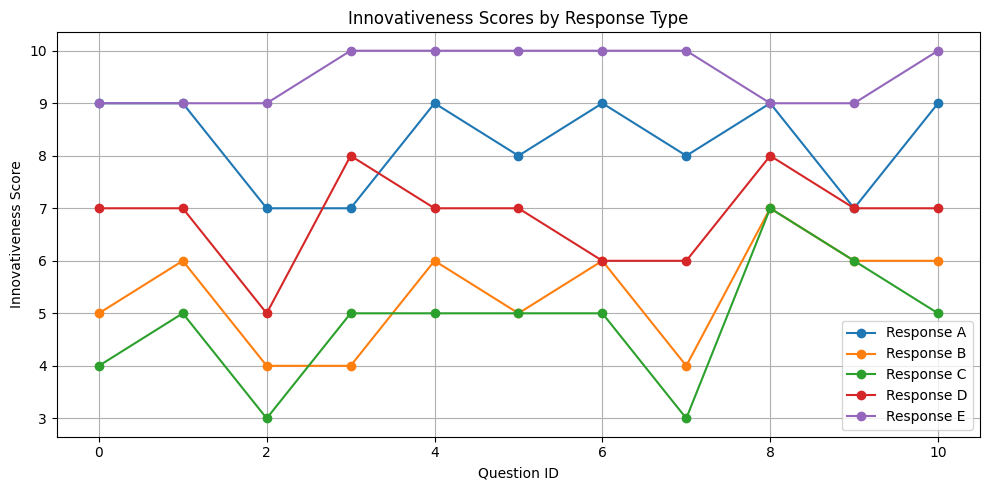

In [56]:
plot_innovativeness(df_eval_results)

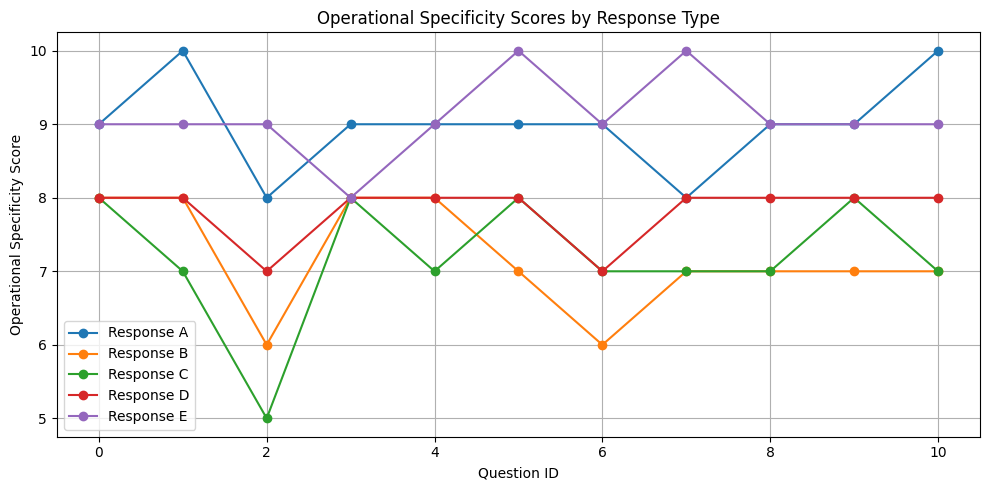

In [94]:
plot_practicality(df_eval_results)